### Med 3: acero inoxidable 30 cm 

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, fftfreq
import pandas as pd 
from scipy.optimize import curve_fit
from scipy.stats import chi2
from uncertainties import ufloat

In [70]:
file_path = "C:/Users/FIUBA/Desktop/Labo 4/mod young/mediciones24-2/med3-24-2-acero-inoxidable-30cm0.csv"
df = pd.read_csv(file_path)

df.columns = ["t","V"]

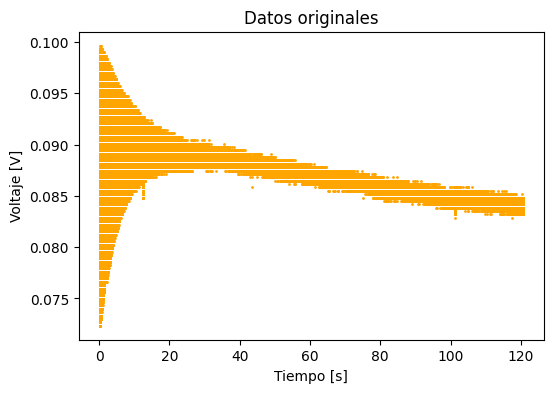

In [71]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

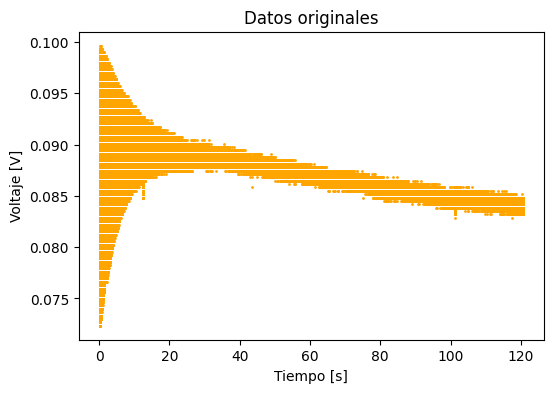

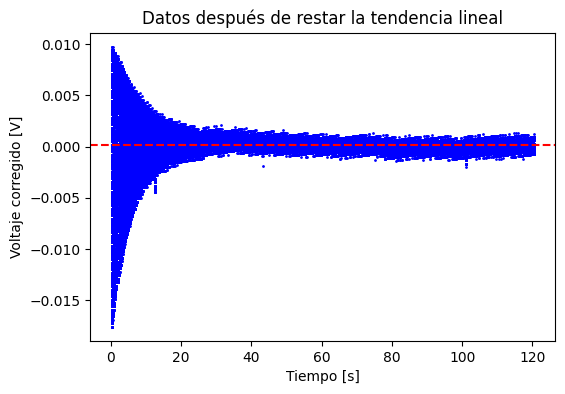

Ecuación de la recta ajustada: V(t) = -0.000050 * t + 0.089928
mean: 0.000139699973765137


In [72]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

# Seleccionar los últimos puntos para el ajuste lineal (por ejemplo, últimos 50% de los datos)
fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

# Ajuste lineal (mínimos cuadrados)
p = np.polyfit(df_tail["t"], df_tail["V"], 1)  # p[0] es la pendiente, p[1] es la intersección

recta_ajustada = np.polyval(p, df["t"])

df["V1_corregido"] = df["V"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V1_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V1_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V1_corregido'])}")

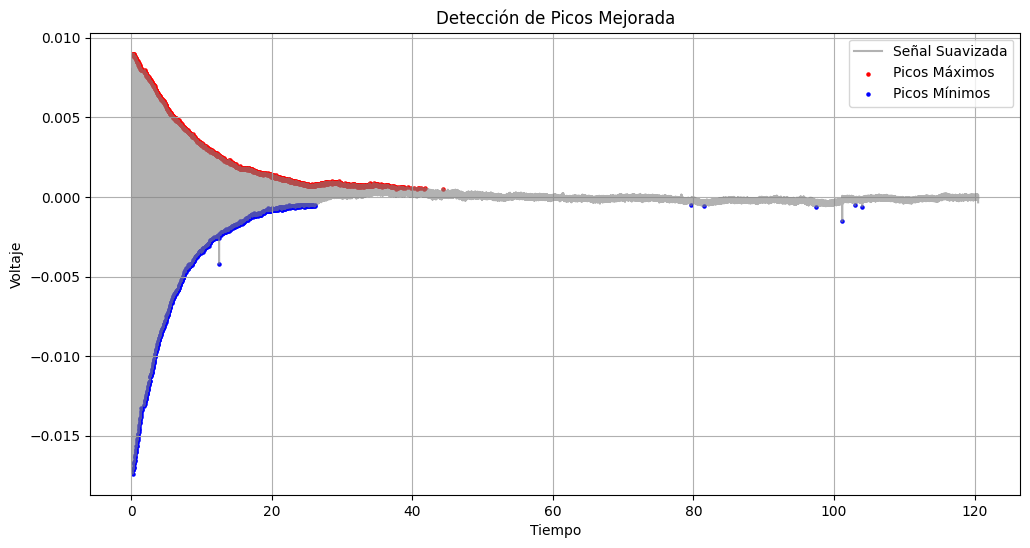

In [59]:
offset = np.mean(df["V1_corregido"].iloc[-2000:])  # Promedio de los últimos 2000 datos
V_ajustada = df["V1_corregido"] - offset

# Suavizado opcional para reducir ruido
V_suavizada = savgol_filter(V_ajustada, window_length=51, polyorder=3)

# Detección de picos con mejores parámetros
peaks_max, _ = find_peaks(V_suavizada, height=0.0005, distance=100, prominence=0.0005)
peaks_min, _ = find_peaks(-V_suavizada, height=0.0005, distance=100, prominence=0.0005)

# Extraer valores de los picos
t_max, V_max = df["t"].iloc[peaks_max], V_suavizada[peaks_max]
t_min, V_min = df["t"].iloc[peaks_min], V_suavizada[peaks_min]

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df["t"], V_suavizada, label="Señal Suavizada", color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', s=5)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', s=5)
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos Mejorada')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\FIUBA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


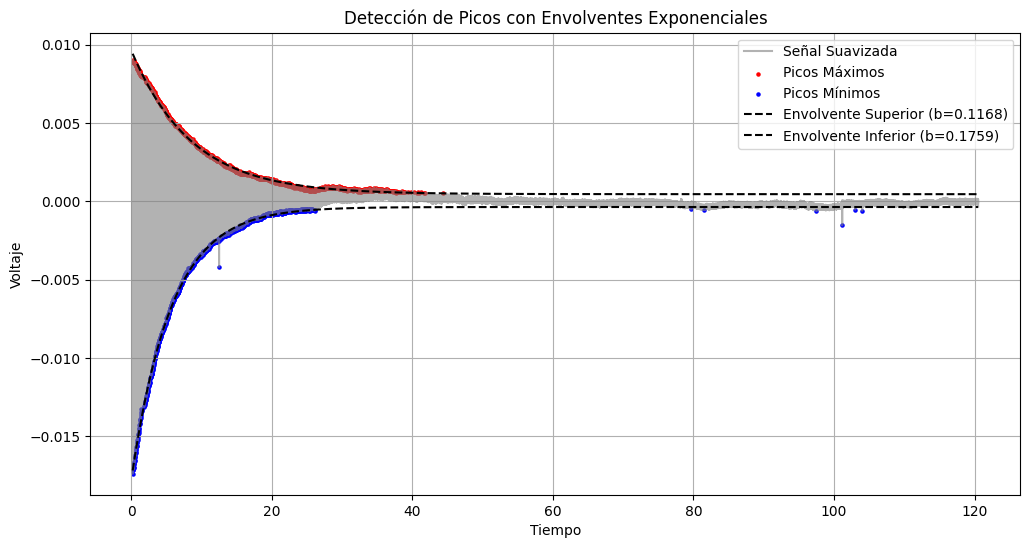

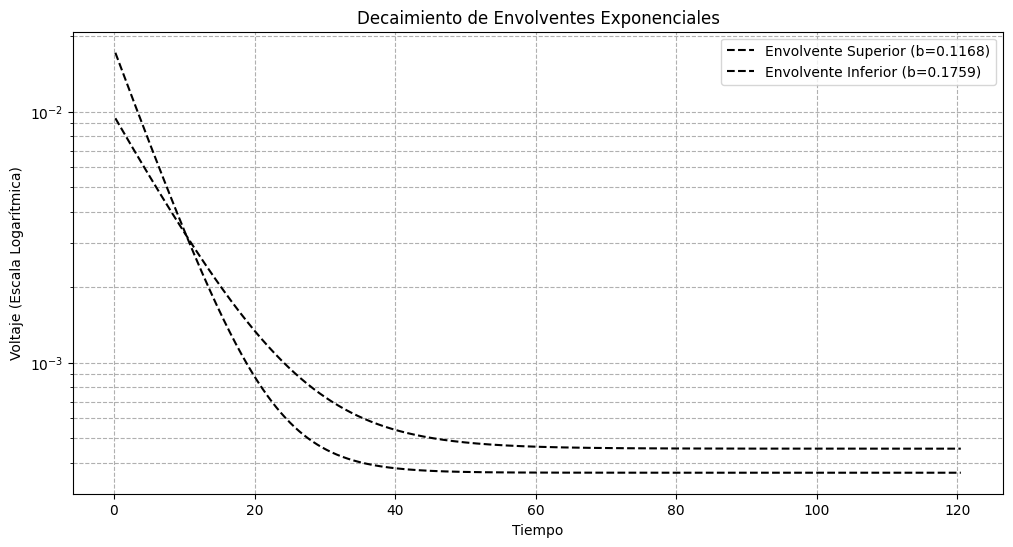

In [60]:

offset = np.mean(df["V1_corregido"].iloc[-2000:])  # Promedio de los últimos 2000 datos
V_ajustada = df["V1_corregido"] - offset

# Suavizar la señal para mejorar la detección de picos
V_suavizada = savgol_filter(V_ajustada, window_length=51, polyorder=3)

# Detectar picos máximos y mínimos
peaks_max, _ = find_peaks(V_suavizada, height=0.0005, distance=100, prominence=0.0005)
peaks_min, _ = find_peaks(-V_suavizada, height=0.0005, distance=100, prominence=0.0005)

# Extraer valores de los picos
t_max, V_max = df["t"].iloc[peaks_max], V_suavizada[peaks_max]
t_min, V_min = df["t"].iloc[peaks_min], V_suavizada[peaks_min]

# Definir función exponencial para ajuste
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajustar exponencial a los picos máximos
params_max, _ = curve_fit(exp_func, t_max, V_max, p0=(0.01, 0.1, 0))
envelope_max = exp_func(df["t"], *params_max)

# Ajustar exponencial a los picos mínimos
params_min, _ = curve_fit(exp_func, t_min, V_min, p0=(-0.01, 0.1, 0))
envelope_min = exp_func(df["t"], *params_min)

# Extraer las constantes de decaimiento
b_max = params_max[1]  # Tasa de decaimiento de la envolvente superior
b_min = params_min[1]  # Tasa de decaimiento de la envolvente inferior

# Graficar en escala normal
plt.figure(figsize=(12, 6))
plt.plot(df["t"], V_suavizada, label="Señal Suavizada", color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', s=5)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', s=5)
plt.plot(df["t"], envelope_max, label=f"Envolvente Superior (b={b_max:.4f})", color="black", linestyle="dashed")
plt.plot(df["t"], envelope_min, label=f"Envolvente Inferior (b={b_min:.4f})", color="black", linestyle="dashed")
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos con Envolventes Exponenciales')
plt.legend()
plt.grid(True)
plt.show()

# Graficar en escala semilogarítmica para ver el decaimiento
plt.figure(figsize=(12, 6))
plt.semilogy(df["t"], np.abs(envelope_max), label=f"Envolvente Superior (b={b_max:.4f})", color="black", linestyle="dashed")
plt.semilogy(df["t"], np.abs(envelope_min), label=f"Envolvente Inferior (b={b_min:.4f})", color="black", linestyle="dashed")
plt.xlabel('Tiempo')
plt.ylabel('Voltaje (Escala Logarítmica)')
plt.title('Decaimiento de Envolventes Exponenciales')
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()


Frecuencias de los picos detectados en la región 20-100 Hz:
[34.91827687 69.81992995]


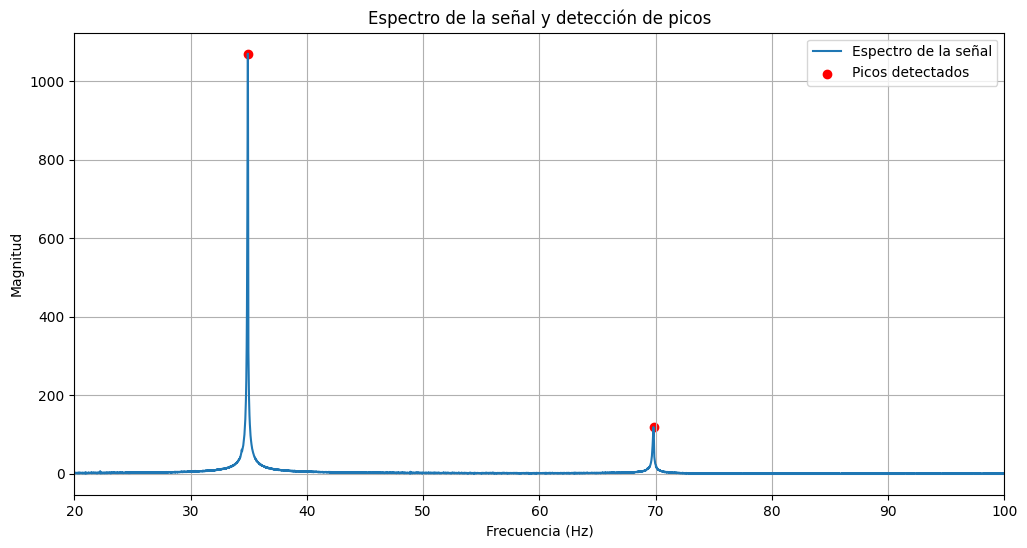

In [61]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(df["V1_corregido"][-num_puntos_finales:])
V_ajustada = df["V1_corregido"] - offset  # Restar el offset para centrar la señal

# Obtener el tiempo de muestreo
dt = np.mean(np.diff(df["t"]))  # Diferencia promedio entre puntos de tiempo
fs = 1 / dt  # Frecuencia de muestreo

# Aplicar FFT
N = len(V_ajustada)
frequencies = fftfreq(N, d=dt)  # Eje de frecuencias
spectrum = np.abs(fft(V_ajustada))  # Magnitud del espectro

# Detectar picos en el espectro
peaks, _ = find_peaks(spectrum, height=np.max(spectrum) * 0.1)

# Obtener frecuencias de los picos
peak_freqs = frequencies[peaks]

# Filtrar las frecuencias entre 20 y 80 Hz
peak_freqs_filtered = peak_freqs[(peak_freqs >= 20) & (peak_freqs <= 100)]

# Imprimir las frecuencias detectadas en la región 20-80 Hz
print("Frecuencias de los picos detectados en la región 20-100 Hz:")
print(peak_freqs_filtered)

# Graficar el espectro con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N // 2], spectrum[:N // 2], label="Espectro de la señal")  # Solo parte positiva
plt.scatter(peak_freqs_filtered, spectrum[peaks[(peak_freqs >= 20) & (peak_freqs <= 100)]], 
            color='red', label="Picos detectados", marker='o')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.xlim(20, 100)
plt.title("Espectro de la señal y detección de picos")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
N = len(V_ajustada)
print(N)


2998919


### Calculamos E

In [31]:
L = 0.227  
n = 1  

k_n = (n * np.pi) / L
k_n

13.839615214051951

In [ ]:
rho = 8960 * (np.pi * (d / 2) ** 2)
print(rho)
f1= 34.91827687

0.1759+/-0.0007


In [50]:
# Parámetros físicos (ajusta según tu material y geometría)
d = 0.01  # diámetro en metros
rho = 7850*np.pi*d**2 / 4 # densidad en kg/m³ (ejemplo para acero)
f_n = 34.9349  # frecuencia medida en Hz
k_n = 13.8396  # número de onda, revisa si es correcto
alpha = 0  # Si no tienes amortiguamiento, puedes tomar α=0

# Cálculos intermedios
A = (np.pi * d**2) / 4  # Área de la sección transversal
rho_l = rho * A  # Densidad lineal
I = (np.pi * d**4) / 64  # Momento de inercia
omega_n = 2 * np.pi * f_n  # Frecuencia angular

# Cálculo del módulo de Young
E = (rho_l * (omega_n**2 + alpha**2)) / (I * k_n**4)

print(f"Módulo de Young: {E:.2e} Pa")

Módulo de Young: 1.30e+05 Pa


In [51]:
rho = 7850  # Densidad en kg/m³ (para acero)
A = np.pi * (d ** 2) / 4  # Área de la sección transversal
rho_l = rho * A  # Densidad lineal


In [53]:
# NO asumimos que es completamente cobre
alfa = 0.20296
d = 0.6/100 # en metros
rho = (123/1000)*(1/(0.28))  #del acero
I = (np.pi * (d)**4)/64
L = 0.28 #en metros
k = 1.875/L
frecuencia_dominante = 34.93490067

#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print(f"Módulo de Young: {E / 1e9:.2f} GPa")


Módulo de Young: 165.45 GPa


In [68]:
L_err = 0.005 
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/2998919 # frec de meustreo/numero de puntos de la fft
alpha_err = 0.0027 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alfa, alpha_err)
d_u = ufloat(d, d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + alfa_u**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 165.45+/-11.87 GPa
